In [1]:
%load_ext autoreload
%autoreload 2

import os
import re
import os
import pandas as pd
import ast
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from cycler import cycler
import numpy as np
from matplotlib.gridspec import GridSpec

In [2]:
def return_proper_model_name(model_name):
    if 'disco' in model_name:
        return 'DiscoLeo-Llama-3-8B-Instruct'
    if 'llama' in model_name and 'disco' not in model_name:
        return 'Llama-3.1-8B-Instruct'
    if 'leolm' in model_name:
        return 'LeoLM-Mistral-7B-Chat'
    if 'mistral' in model_name and 'leolm' not in model_name:
        return 'Mistral-7B-Instruct'
def return_model_color(model_name):
    if 'disco' in model_name:
        return sns.color_palette("colorblind", 11)[4] # '#CB78BC'
    if 'llama' in model_name and 'disco' not in model_name:
        return sns.color_palette("colorblind", 11)[0] #'#0273B2'
    if 'leolm' in model_name:
        return sns.color_palette("colorblind", 11)[1] #'#DE8F05'
    if 'mistral' in model_name and 'leolm' not in model_name:
        return sns.color_palette("colorblind", 11)[3] #'#D55E00'
    
def paramix_parser(paramix):
    print(paramix)
    bs = int(paramix[len('bs'):paramix.find('ga')])
    print(bs)
    ga_steps = int(paramix[paramix.find('ga') + 2:paramix.find('dv')])
    print(ga_steps)
    gpu_count = int(paramix[paramix.find('dv') + 2:paramix.find('lr')])
    print(gpu_count)
    lr = paramix[paramix.find('lr')+2:]
    print(lr)
    return bs, ga_steps, gpu_count, lr

def return_visual_element(element, i):
    colors = sns.color_palette("colorblind", 11)
    linestyles = ["-", "--", ":", "-.", (0, (3, 1, 1, 1)), (0, (5, 2, 2, 2)), 
              (0, (1, 1)), (0, (3, 1, 1, 1, 1, 1)), (0, (5, 1, 1, 1)), 
              (0, (5, 2, 2, 2, 2, 2)), (0, (3, 3, 1, 1))]
    markers = ["o", "s", "^", "D", "v", "p", "h", "X", "*", "P", "+"]
    if element == 'color':
        if i == 0: # disco
            return return_model_color('disco')
        elif i == 1: # leo mistral
            return return_model_color('leolm')
        elif i == 2: # llama
            return return_model_color('llama')
        elif i == 3: # mistral
            return return_model_color('mistral')
        #return colors[i]
    if element == 'linestyle':
        return linestyles[i]
    if element == 'marker':
        return markers[i]
    
def generate_from_key(key, label_or_color_or_linestyle):
    import re
    match = re.match(r'bs(\d+)ga(\d+)dv(\d+)lr([\de.-]+)', key)
    if match:
        bs, ga, dv, lr = map(float, match.groups())
        ebs = int(bs * ga * dv)
        if label_or_color_or_linestyle == 'label':
            return f"EBS {ebs}, LR {lr}"
        if key == 'bs16ga1dv1lr1e-4':
            idx = 0
        if key == 'bs16ga1dv1lr5e-5':
            idx = 1
        if key == 'bs16ga1dv1lr1e-5':
            idx = 2
        if key == 'bs16ga2dv1lr1e-4':
            idx = 3
        if key == 'bs16ga2dv1lr5e-5':
            idx = 4
        if key == 'bs16ga2dv1lr1e-5':
            idx = 5
        if key == 'bs16ga4dv1lr1e-4':
            idx = 6
        if key == 'bs16ga4dv1lr5e-5':
            idx = 7
        if key == 'bs16ga4dv1lr1e-5':
            idx = 8
        return return_visual_element(label_or_color_or_linestyle, idx)

    else:
        if label_or_color_or_linestyle == 'label':
            if key == 'sft_disco_llama8b1':
                return return_proper_model_name('disco') + r'$^{1}$'
            if key == 'sft_disco_llama8b2':
                return return_proper_model_name('disco') + r'$^{2}$'
            if key == 'sft_leolm_mistral7b':
                return return_proper_model_name('leolm') + r'$^{1}$'
            if key == 'sft_llama8b1':
                return return_proper_model_name('llama') + r'$^{1}$'
            if key == 'sft_llama8b2':
                return return_proper_model_name('llama') + r'$^{2}$'
            if key == 'sft_mistral7b':
                return return_proper_model_name('mistral') + r'$^{1}$'
            
        elif label_or_color_or_linestyle == 'linestyle':
            if 'sft_disco_llama8b' in key:
                idx = 0
                if '2' in key:
                    idx = 1
            if key == 'sft_leolm_mistral7b':
                idx = 2
            if 'sft_llama8b' in key:
                idx = 3
                if '2' in key:
                    idx = 4
            if key == 'sft_mistral7b':
                idx = 5
            return return_visual_element(label_or_color_or_linestyle, idx)
        else:
            if 'sft_disco_llama8b' in key:
                idx = 0
            if key == 'sft_leolm_mistral7b':
                idx = 1
            if 'sft_llama8b' in key:
                idx = 2
            if key == 'sft_mistral7b':
                idx = 3
            return return_visual_element(label_or_color_or_linestyle, idx)
        
def plot_sft_progression(type, model_or_paramix, df_dict, rnge = 'free'):

    print(type)
    metrics = ["bert", "bleu", "sari", "leng", "ease", "wstf", "equl", "loss"] #"empt", "lang", "lens"
    
    plot_df_dict = df_dict.copy()
    for metric in plot_df_dict.keys():
        plot_df_dict[metric] = plot_df_dict[metric].loc[:, plot_df_dict[metric].columns.str.contains('bs|sft|index|base')]

    fig = plt.figure(figsize=(11, 11), constrained_layout=True)
    gs = GridSpec(3, 3, figure=fig, wspace = 0.4, hspace=0.5)
 
    #for i in range(len(metrics), len(axes)):  # Hide extra unused subplot
    #    fig.delaxes(axes[i])

    ylabsize = 10
    for i, metric in enumerate(metrics):
        ax = fig.add_subplot(gs[i])
        ax.grid(True, axis='y')
        df = plot_df_dict[metric]
        x = df['index'].astype(int)
        for column in df.columns:
            if column != 'index':
                ax.plot(x, df[column], label=generate_from_key(column, 'label'), color=generate_from_key(column, 'color'), linestyle=generate_from_key(column, 'linestyle'), marker=generate_from_key(column, 'marker'))
        if metric == 'bert':
            ax.set_ylabel(r'Avg. Compl.$\rightarrow$Simp. BERTScore F1', fontsize = ylabsize)
        if metric == 'bleu':
            ax.set_ylabel(r'Avg. Compl.$\rightarrow$Simp. BLEU Score', fontsize = ylabsize)
        if metric == 'sari':
            ax.set_ylabel(r'Avg. Compl.$\rightarrow$Simp. SARI Score', fontsize = ylabsize)
        if metric == 'ease':
            ax.set_ylabel('Avg. Simp. Flesch Reading Ease', fontsize = ylabsize)
        if metric == 'empt':
            ax.set_ylabel('Prop. Simp. Empty (< 10 char)', fontsize = ylabsize)
        if metric == 'equl':
            ax.set_ylabel('Prop. Simp. Equal to Complex', fontsize = ylabsize)
        if metric == 'wstf':
            ax.set_ylabel(r'Avg. Simp. $\text{WSTF}_4$', fontsize = ylabsize)
        if metric == 'lang':
            ax.set_ylabel('Prop. Simp. Classified as German', fontsize = ylabsize)
        if metric == 'leng':
            ax.set_ylabel('Avg. Word Count of Simp.', fontsize = ylabsize)
        if metric == 'loss':
            ax.set_ylabel('Cross-Entropy Loss', fontsize = ylabsize)
        if metric == 'lens':
            ax.set_ylabel('Avg. LENS Simp. Rating', fontsize = ylabsize)
        ax.set_xlabel('Training Instances', fontsize = ylabsize)

        #ax.set_ylabel('')

        #if i == 5:
        #    ax.text(0.5, -0.15, '* According to the Python library langdetect', ha='right', va='top', 
        #            transform=ax.transAxes, fontsize=10, style='italic')
        if rnge == 'reasonable':   
            if i == 0:
                ax.set_ylim(0.84, 0.95)
            if i == 1:
                ax.set_ylim(0.2, 0.65)
            if i == 2:
                ax.set_ylim(37, 47)
        if i == 6:
            ax.set_ylim(0, 0.25)
        #if i == 7:
        #    ax.set_ylim(0, 0.20)
        if i == 8:
            ax.set_ylim(0.95,1)
        if i == -1:
            ax.legend(loc='lower right', frameon=True)   
        if i == -1:
            ax.legend(loc='upper right', frameon=True)   
        if i == -1:
            ax.legend(loc='upper right', frameon=True)     

        # ax.axvline(x=3000, color='gray', linestyle=':', linewidth=2)
        ax.set_xticks(range(0, 3601, 400))
        ax.tick_params(axis='both', labelsize=ylabsize-2)
        ax.set_xticklabels(ax.get_xticks(), rotation=90)
    # fig.text(0.5, 0.01, 'The dashed vertical line indicates the training step when we save a LLaMA 8B Instruct checkpoint for DPO.', ha='center', va='top', fontsize=10)

    if 'bs' in model_or_paramix:
        bs, ga_steps, gpu_count, lr = paramix_parser(model_or_paramix)
        title = f'EBS{bs*ga_steps*gpu_count}, {lr}'
    if model_or_paramix == 'bs16ga1dv1lr1e-4':
        title = 'SFT Cross-Model Comparison'

    if model_or_paramix == 'disco_llama8b':
        title = 'Disco Llama 8B'

    if type == 'cross_paramix':
        if model_or_paramix == 'disco_llama8b':
            title = "Parameter Mix Grid Search: DiscoLeo Llama 8B"

    #fig.suptitle(title, fontsize=20, y=1.06)
    if type == 'cross_paramix':
        fig.legend(handles=ax.get_legend_handles_labels()[0], labels=ax.get_legend_handles_labels()[1], loc="upper center", ncol=1, fontsize=10, frameon=True, bbox_to_anchor=(0.79, 0.28)) 
    if type == 'cross_model':
        fig.legend(handles=ax.get_legend_handles_labels()[0], labels=ax.get_legend_handles_labels()[1], loc="upper center", ncol=1, fontsize=10, frameon=True, bbox_to_anchor=(0.79, 0.28)) 
    #plt.subplots_adjust(top=0.80)
    plt.tight_layout()
    #plt.subplots_adjust(hspace=0.4)

    #plt.show()

    
    #fig.delaxes(axes[10])
    #fig.delaxes(axes[8])
    #fig.delaxes(axes[7])

    #axes[7] = axes[9]
    
    plt.savefig('figures/results_sft_modelmix.png', dpi=300)

cross_model
bs16ga1dv1lr1e-4
16
1
1
1e-4


C:\Users\HP\AppData\Local\Temp\ipykernel_27072\152630684.py:219: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\HP\AppData\Local\Temp\ipykernel_27072\152630684.py:219: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


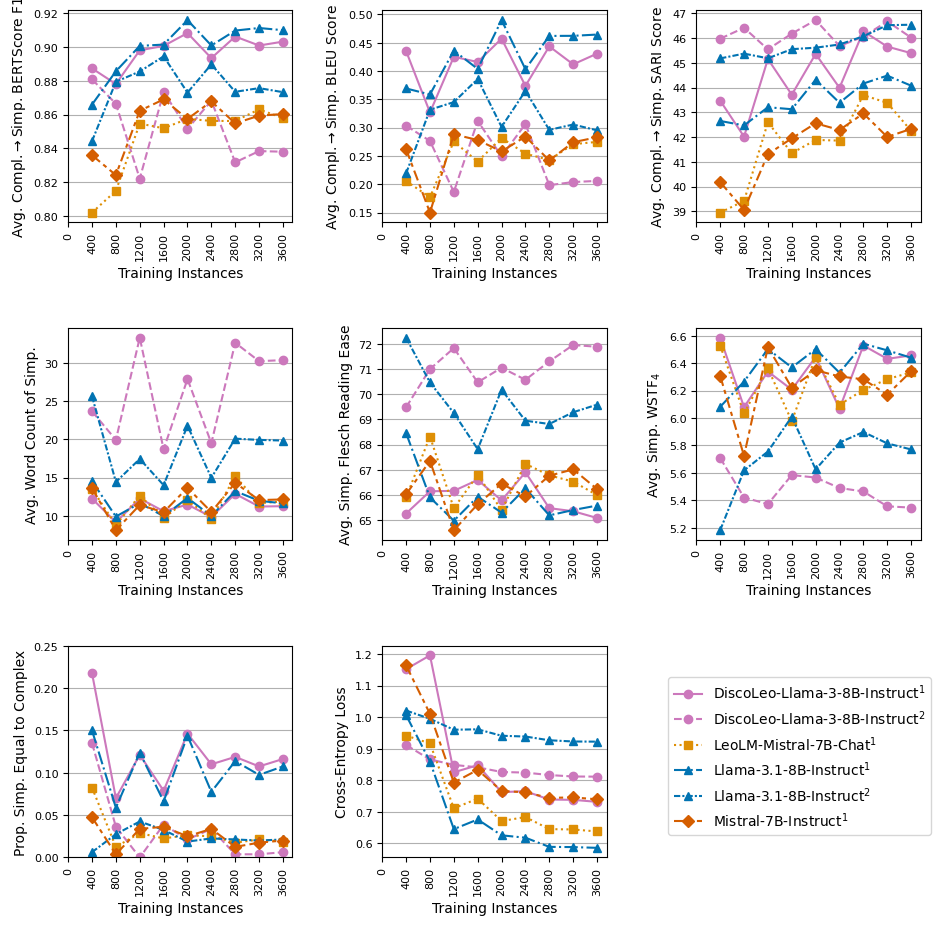

In [3]:
#df_dict = sft_progression("cross_model", "bs16ga1dv1lr1e-4", 400)
df = pd.read_json('outputs/sft_dev.jsonl', orient="records", lines=True)

df_dict = {}
for metric in df['metric'].unique():
    df_dict[metric] = df[df['metric'] == metric]

plot_sft_progression("cross_model", "bs16ga1dv1lr1e-4", df_dict)